## Perlin spontaneous

Copyright 2019 Sebastian Spreizer

The MIT License

In [1]:
%matplotlib notebook

import numpy as np
import nest
import pylab as pl

import lib.connectivity_map as cm
import lib.lcrn_network as lcrn
import lib.animation as animation
import lib.plot3d as pl3d
import lib.colormap as cmap
import lib.activity_sequence as seq

#### Perlin landscape for connectivity

<IPython.core.display.Javascript object>


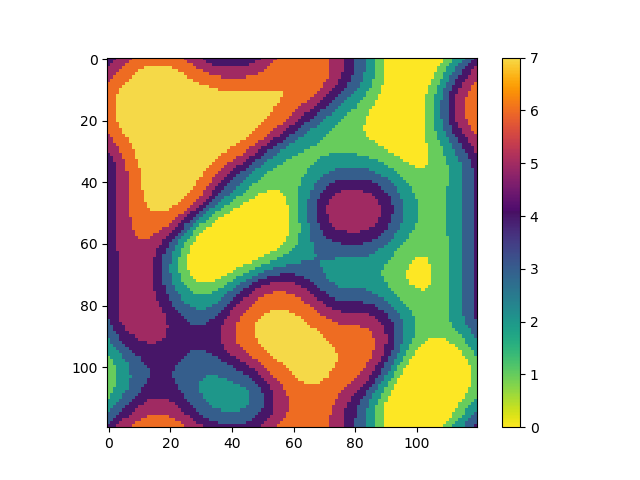

In [2]:
# Network size
nrowE = ncolE = 120
nrowI = ncolI = 60
npopE = nrowE * ncolE
npopI = nrowI * ncolI

nrow = nrowE
landscape = np.round(cm.Perlin_uniform(nrow, size=3, base=1) * 7).astype(int)
move = cm.move(nrow)

fig,ax = pl.subplots(1)
im = ax.imshow(landscape.reshape(nrow,-1), cmap=cmap.virno())
pl.colorbar(im,ax=ax)

#### Set Kernel Status

In [3]:
np.random.seed(0)
nest.ResetKernel()
nest.SetKernelStatus({
    'local_num_threads': 4,
    'resolution': 0.1,
})

#### Create nodes

In [4]:
popE = nest.Create('iaf_psc_alpha', npopE, params={
    "C_m":      250.0,
    "E_L":      -70.0,
    "V_reset":  -70.0,
    "V_th":     -55.0,
    "t_ref":      2.0,
    "tau_m":     10.0,
    "tau_minus": 20.0,
    "tau_syn_ex": 5.0,
    "tau_syn_in": 5.0,
})

popI = nest.Create('iaf_psc_alpha', npopI, params={
    "C_m":      250.0,
    "E_L":      -70.0,
    "V_reset":  -70.0,
    "V_th":     -55.0,
    "t_ref":      2.0,
    "tau_m":     10.0,
    "tau_minus": 20.0,
    "tau_syn_ex": 5.0,
    "tau_syn_in": 5.0,
})
pop = popE + popI

# Create devices
ngE = nest.Create('noise_generator')
ngI = nest.Create('noise_generator')
ng = ngE + ngI

stimE = nest.Create('noise_generator')
sd = nest.Create('spike_detector')

#### Connect nodes

In [5]:
offsetE = popE[0]
offsetI = popI[0]

p = 0.05
stdE = 9
stdI = 12
g = 8
shift = 1


for idx in range(npopE):
    # E-> E
    source = idx, nrowE, ncolE, nrowE, ncolE, int(p * npopE), stdE, False
    targets, delay = lcrn.lcrn_gauss_targets(*source)
    targets = (targets + shift * move[landscape[idx] % len(move)]) % npopE
    targets = targets[targets != idx] 
    nest.Connect([popE[idx]], (targets + offsetE).tolist(), syn_spec={'weight': 10.0})

    # E-> I
    source = idx, nrowE, ncolE, nrowI, ncolI, int(p * npopI), stdE / 2, False
    targets, delay = lcrn.lcrn_gauss_targets(*source)
    nest.Connect([popE[idx]], (targets + offsetI).tolist(), syn_spec={'weight': 10.0})

for idx in range(npopI):
    # I-> E
    source = idx, nrowI, ncolI, nrowE, ncolE, int(p * npopE), stdI, False
    targets, delay = lcrn.lcrn_gauss_targets(*source)
    nest.Connect([popI[idx]], (targets + offsetE).tolist(), syn_spec={'weight': g * -10.0})

    # I-> I
    source = idx, nrowI, ncolI, nrowI, ncolI, int(p * npopI), stdI / 2, False
    targets, delay = lcrn.lcrn_gauss_targets(*source)
    targets = targets[targets != idx]
    nest.Connect([popI[idx]], (targets + offsetI).tolist(), syn_spec={'weight': g * -10.0})

# Connect noise input device to all neurons
nest.Connect(ngE, popE, syn_spec={'weight': 10.0})
nest.Connect(ngI, popI, syn_spec={'weight': 10.0})

centerE = nrowE * nrowE // 2 + nrowE // 2
source = centerE, nrowE, ncolE, nrowE, ncolE, 50, 4
targets, delay = lcrn.lcrn_gauss_targets(*source)
targets = np.unique(targets)
nest.Connect(stimE, (targets + offsetE).tolist(), syn_spec={'weight': 10.0})

nest.Connect(pop, sd)

#### Warming up

In [6]:
nest.SetStatus(ng, params={'mean': 0., 'std': 50.})
nest.Simulate(250.)
nest.SetStatus(ng, params={'mean': 15., 'std': 30.})
nest.Simulate(250.)

#### Start simulation

In [7]:
for i in range(4):
    nest.SetStatus(stimE, params={'mean': 50., 'std': 0.})
    nest.Simulate(50.)
    nest.SetStatus(stimE, params={'mean': 0., 'std': 0.})
    nest.Simulate(450.)

#### Plot spiking activity

<IPython.core.display.Javascript object>


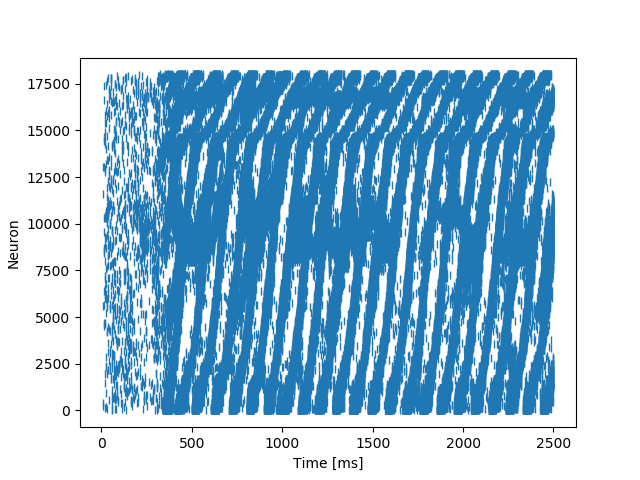

Text(0,0.5,'Neuron')

In [9]:
sdE = nest.GetStatus(sd, 'events')[0]
ts, gids = sdE['times'], sdE['senders']
fig, ax = pl.subplots(1)
ax.plot(ts, gids, '|')
ax.set_xlabel('Time [ms]')
ax.set_ylabel('Neuron')

In [10]:
idx = gids - offsetE < npopE
gids, ts = gids[idx] - offsetE, ts[idx]
time = nest.GetKernelStatus('time')

ts_bins = np.arange(time-2000., time, 10.)
h = np.histogram2d(ts, gids, bins=[ts_bins, range(npopE + 1)])[0]
hh = h.reshape(-1, nrowE, ncolE)

<IPython.core.display.Javascript object>


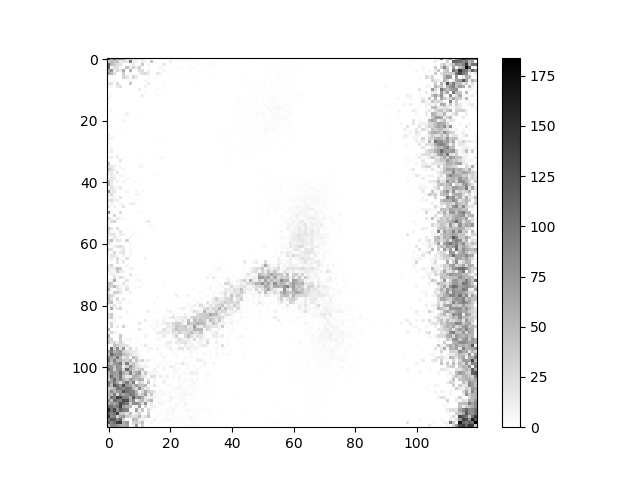

In [11]:
fig,ax = pl.subplots(1)
im = ax.imshow(hh.sum(0) / 2., cmap='binary')
pl.colorbar(im,ax=ax)

<IPython.core.display.Javascript object>


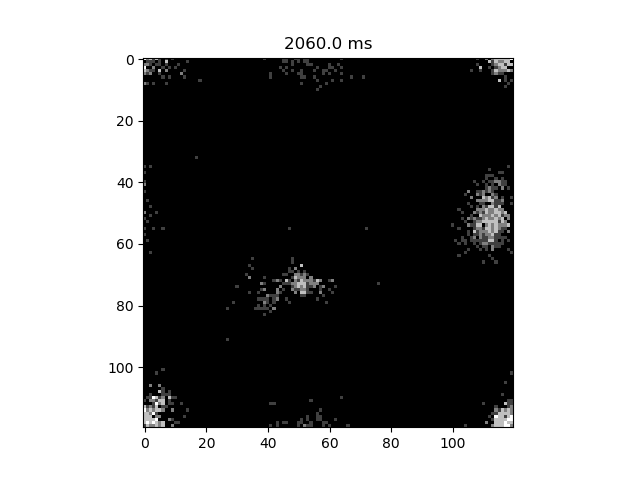

In [12]:
fig, ax = pl.subplots(1)
im1 = ax.imshow(hh[0], vmin=0, vmax=np.max(hh), cmap='binary_r')
anim = animation.imshow(fig, ax, im1, hh, ts_bins)

In [12]:
#animation.HTML(anim.to_jshtml())

In [13]:
#fig,ax = pl3d.scatter(ts,gids%nrow,gids//nrow)
#ax.set_xlim(time-1000.,time)

In [14]:
# fig,ax = pl.subplots(1,2)
# ax[0].imshow(landscape.reshape(nrow,-1), cmap=cmap.virno(), vmin=0, vmax=2*np.pi)
# ax[1].imshow(W_EE.reshape(nrow,-1))

In [13]:
td = 3.14
eps = 3.14

In [14]:
clusters1, sequences1 = seq.identify_vectors(ts, gids, nrowE, ncolE, steps=10., width=10., td=td, eps=eps)

In [15]:
center = int(nrow * nrow/2 + nrow/2)
clusters2, sequences2 = seq.identify_vectors(ts, (gids + center) % npopE, nrowE, ncolE, steps=10., width=10., td=td, eps=eps)

In [16]:
c1 = np.copy(clusters1[1])
c2 = clusters2[1]

for ii in range(10):
    x = np.unique(list(zip(c2,c1)), axis=0)
    x2,x1 = x.T
    x2_set = np.unique(x2, return_counts=True)
    b2 = x2_set[0][x2_set[1] > 1][1:]
    for i in b2:
        dd = x1[x2 == i]
        dd = dd[dd>-1]
        idx = np.in1d(c1, dd)
        c1[idx] = dd[0]

c1 = np.unique(c1 + 1, return_inverse=True)[1] - 1

<IPython.core.display.Javascript object>


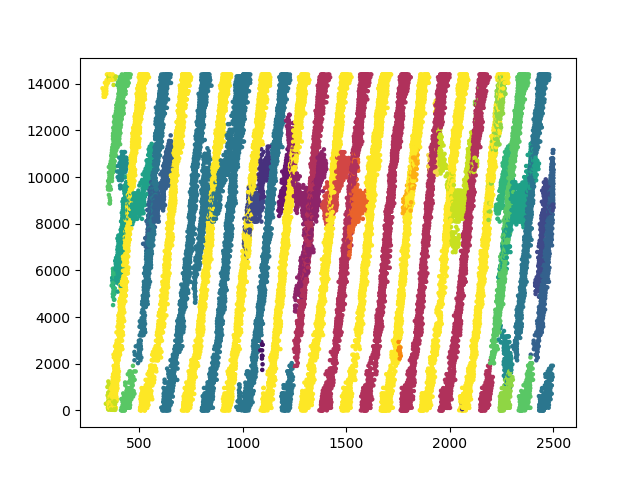

In [17]:
cmod=20
idx = c1 > -1
fig, ax = pl.subplots(1)
ax.scatter(ts[idx][::5], gids[idx][::5], c=c1[idx][::5]%cmod, s=5, cmap=cmap.virno())

<IPython.core.display.Javascript object>


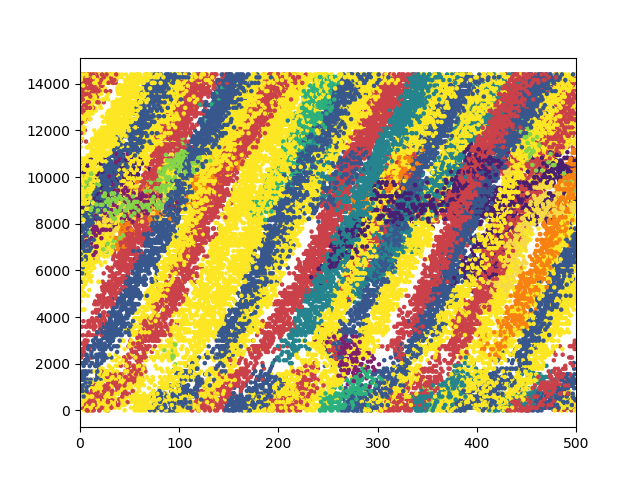

(0, 500)

In [18]:
cmod = 10
idx = c1 > -1
fig, ax = pl.subplots(1)
ax.scatter(ts[idx][::5] % 500., gids[idx][::5], c=c1[idx][::5]%cmod, s=5, cmap=cmap.virno())
ax.set_xlim(0,500)

In [21]:
# fig = pl.figure(figsize=(10,8))
# ax = fig.add_subplot(111, projection='3d')
# x,y,z = ts,gids%nrow,gids//nrow
# ax.scatter(x[idx][::10], y[idx][::10], z[idx][::10], c=c[idx][::10]%cmod, s=5, cmap=cmap.virno())
# ax.set_ylim(0,nrow)
# ax.set_zlim(0,nrow)

<IPython.core.display.Javascript object>


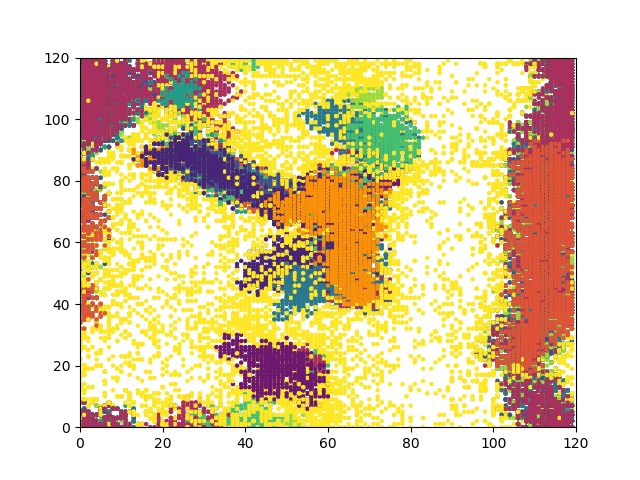

In [20]:
cmod = 10
fig, ax = pl.subplots(1)
ti = ts
xi = gids % nrow
yi = gids // nrow
ci = c1 % cmod
ci[c1 == -1] = -1

scat = ax.scatter(xi, yi, c=ci, s=5, vmin=-1, vmax=cmod, cmap=cmap.virno())
ax.set_xlim(0,nrow)
ax.set_ylim(0,nrow)
anim = animation.scatter(fig, ax, scat, ti, xi, yi, ci, ts_bins)

In [21]:
animation.HTML(anim.to_jshtml())

NameError: name 'np' is not defined

In [24]:
anim.save('EI_networks-stimulus.mp4', fps=10., extra_args=['-vcodec', 'libx264'])